In [2]:
# 1. データ読み込み・データ定義
from tkinter import filedialog
from tkinter import Tk
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from scipy.spatial import ConvexHull, Delaunay
import shap
import xgboost as xgb
from alphashape import alphashape

root = Tk()
root.withdraw()

# 1. read data
csv_file_path = filedialog.askopenfilename(title="Select Test-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))

# 1-1. df define
df = pd.read_csv(csv_file_path)
df_setting = pd.read_excel(Setting_File_path)

feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

# 1-2. mode check @ test-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)


#1-3. data define
target_mode = "2wfF4"
train_df = df[df['Mode'] != target_mode]
test_df = df[df['Mode'] == target_mode]

train_data = train_df[feature_vars]
test_data = test_df[feature_vars]
target_data = train_df[target_variable]

# Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']

Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']


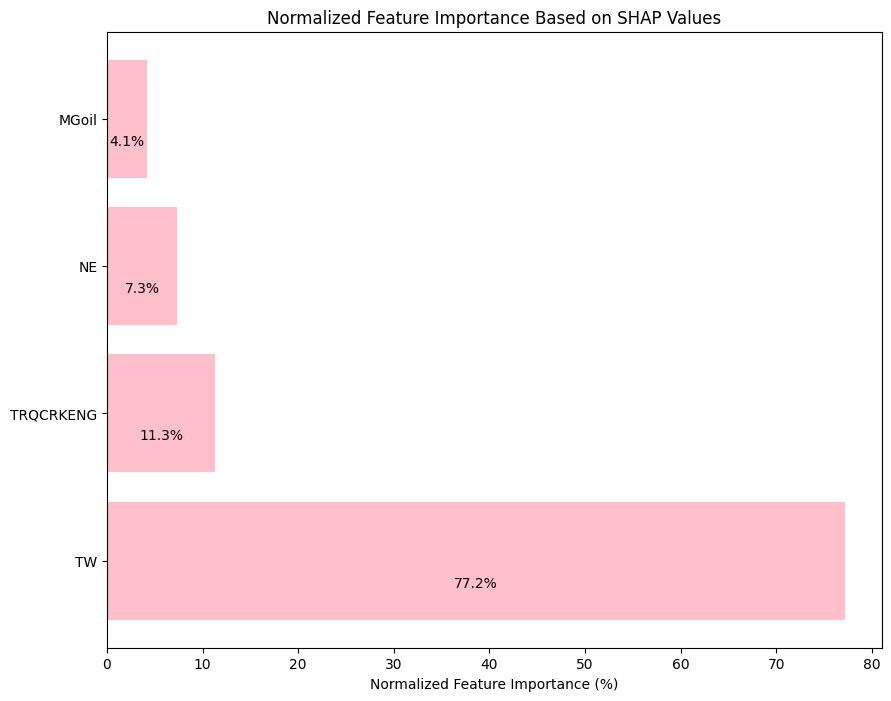

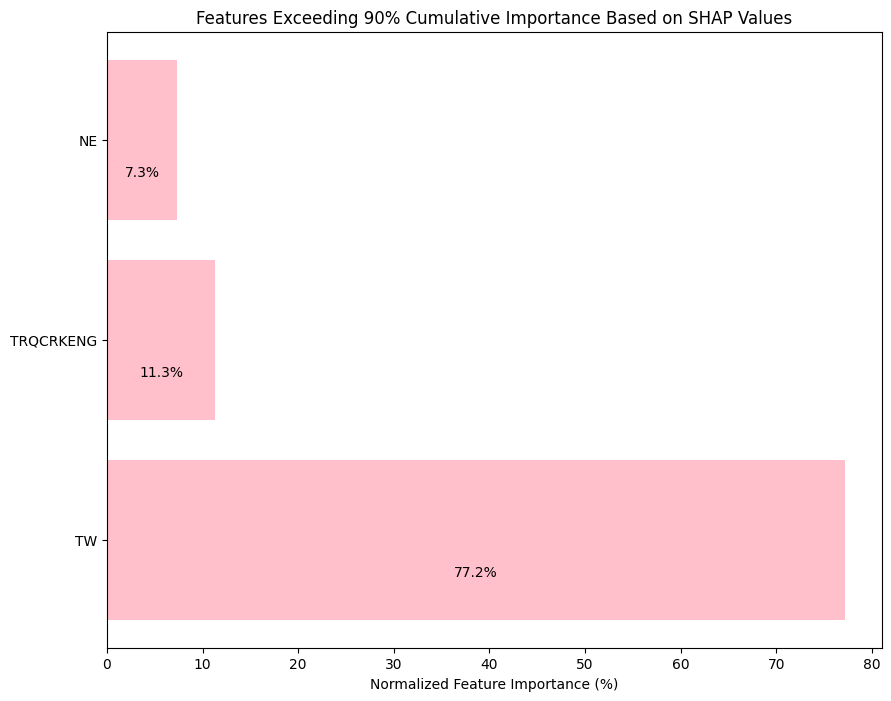

In [16]:
# Train XGBoost model to compute SHAP values
model = xgb.XGBRegressor(n_jobs=-1) # n_jobs=-1で利用できる全CPUコアを使う
model.fit(train_data, target_data) 

# Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(train_data)

# Get feature importances and sort them
feature_importance = np.abs(shap_values.values).mean(axis=0)
sorted_idx = np.argsort(-feature_importance) 
sorted_importance = feature_importance[sorted_idx]

# Normalize feature_importance to sum up to 100%
normalized_importance = (sorted_importance / np.sum(sorted_importance)) * 100

# Visualization 1: Plotting each feature's normalized SHAP importance with percentage labels, sorted by importance
plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(sorted_idx)), normalized_importance, align='center', color='pink')  # Changed bar color to pink
plt.yticks(range(len(sorted_idx)), [feature_vars[i] for i in sorted_idx])  # Now sorted in descending order
plt.xlabel('Normalized Feature Importance (%)')
plt.title('Normalized Feature Importance Based on SHAP Values')

# Add percentage labels on the bars, rounded to 1 decimal place, and aligned to the middle of the bar
for bar in bars:
    plt.gca().text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/4,
                   f"{bar.get_width():.1f}%", color="black", fontsize=10, ha='center', va='bottom')  # Changed text color to black

plt.show()

# Select features with cumulative importance > 0.9
cumulative_importance = np.cumsum(sorted_importance / np.sum(sorted_importance))
selected_features_idx = np.where(cumulative_importance > 0.9)[0][0]  # Get the index where cumulative importance exceeds 90%
selected_features = [feature_vars[sorted_idx[i]] for i in range(selected_features_idx + 1)]  # Include the feature that made it exceed 90%
selected_normalized_importance = normalized_importance[:selected_features_idx + 1]

# Visualization 2: Plotting the selected features that exceed 90% of cumulative importance
plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(selected_features)), selected_normalized_importance, align='center', color='pink')  # Changed bar color to pink
plt.yticks(range(len(selected_features)), [feature_vars[sorted_idx[i]] for i in range(selected_features_idx + 1)])
plt.xlabel('Normalized Feature Importance (%)')
plt.title('Features Exceeding 90% Cumulative Importance Based on SHAP Values')

# Add percentage labels on the bars, rounded to 1 decimal place, and aligned to the middle of the bar
for bar in bars:
    plt.gca().text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/4,
                   f"{bar.get_width():.1f}%", color="black", fontsize=10, ha='center', va='bottom')  # Changed text color to black

plt.show()


Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


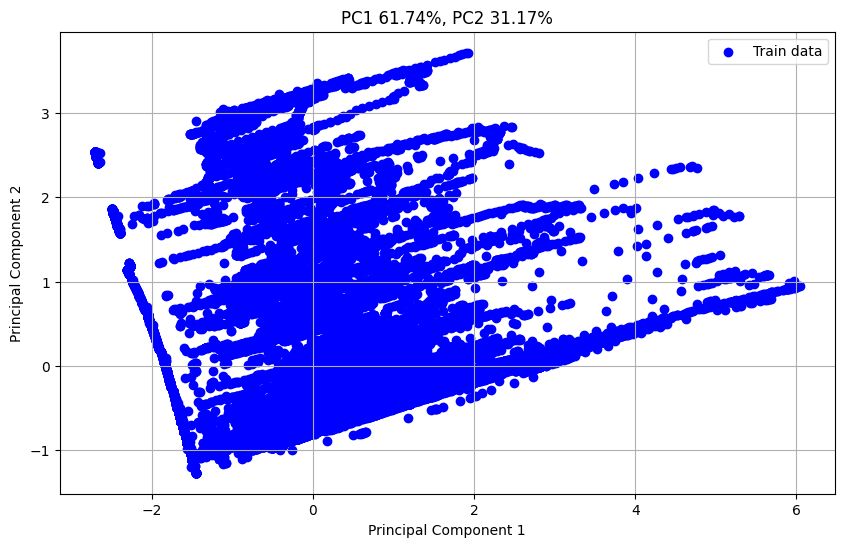

PCA Components (Feature Weights):
           TW  TRQCRKENG        NE
PC1  0.269129   0.677131  0.684882
PC2 -0.962082   0.221772  0.158795


In [36]:
# Dimensionality reduction: PCA + UMAP on top 90% features
scaler = StandardScaler()
selected_train_data = scaler.fit_transform(train_data[selected_features])
selected_test_data = scaler.transform(test_data[selected_features])

# PCA
pca = PCA(n_components=0.9)
pca_train_data = pca.fit_transform(selected_train_data)
pca_test_data = pca.transform(selected_test_data)

# UMAP
umap_model = umap.UMAP(n_components=2, n_jobs=-1)
umap_train_data = umap_model.fit_transform(pca_train_data)
umap_test_data = umap_model.transform(pca_test_data)

# Visualize PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Calculate the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio1 = explained_variance_ratio[0] * 100
explained_variance_ratio2 = explained_variance_ratio[1] * 100

# Add the explained variance ratio to the plot title
plt.title(f'PC1 {explained_variance_ratio1:.2f}%, PC2 {explained_variance_ratio2:.2f}%')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Investigating the feature contributions for each principal component
components_df = pd.DataFrame(pca.components_, columns=selected_features, index=[f'PC{i+1}' for i in range(len(pca.components_))])

# Display the components in the console
print("PCA Components (Feature Weights):")
print(components_df)

# Visualize the feature contributions for the first two principal components
components_df.iloc[:2, :].plot(kind='bar', figsize=(12, 6))
plt.title('Feature Contributions for the First Two Principal Components')
plt.ylabel('Feature Weights')
plt.show()


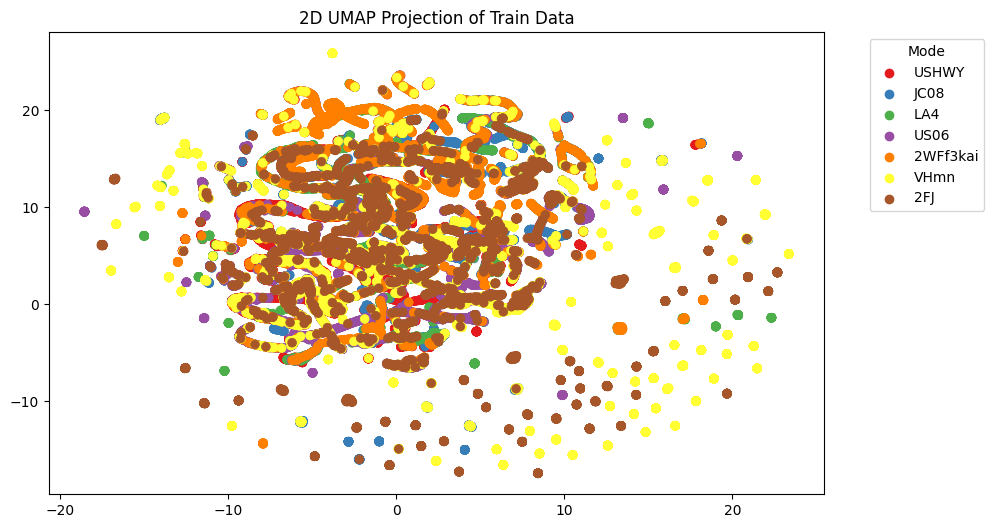

In [24]:
# Visualize the 2D UMAP projection with "Mode" as a hue
plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_train_data[:, 0], y=umap_train_data[:, 1], hue=train_df['Mode'], palette='Set1', s=40, edgecolor=None)
plt.title("2D UMAP Projection of Train Data")
plt.legend(title='Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [29]:
# Approach 1: Kernel Density Estimation (KDE)
kde = KernelDensity()
kde.fit(umap_train_data)
density_train = kde.score_samples(umap_train_data)
density_test = kde.score_samples(umap_test_data)

# Identify low density threshold
low_density_threshold = np.percentile(density_train, 5)
is_low_density_train = density_train < low_density_threshold
is_low_density_test = density_test < low_density_threshold

# Plotting KDE result
plt.figure(figsize=(10, 6))
plt.hist(density_train, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=low_density_threshold, color='red', linestyle='--', label=f'Threshold ({low_density_threshold:.2f})')
plt.title("Density Distribution Using KDE")
plt.legend()
plt.show()


# Visualize low-density areas in UMAP projection
filtered_modes = train_df['Mode'][is_low_density_train]  # Filter the 'Mode' labels based on low-density points

plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_train_data[is_low_density_train, 0], 
                y=umap_train_data[is_low_density_train, 1], 
                hue=filtered_modes, 
                palette='Set1', 
                s=40, 
                edgecolor=None)
plt.title("2D UMAP Projection of Train Data")
plt.legend(title='Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


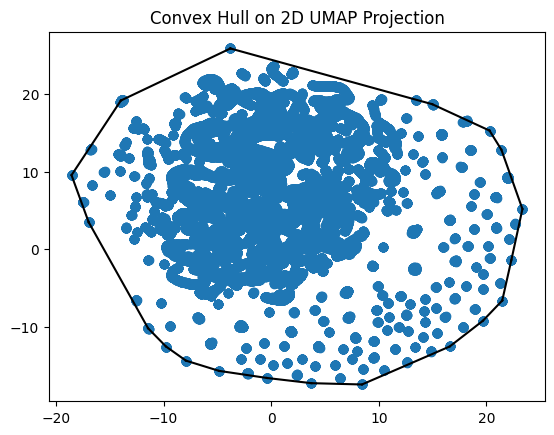

In [30]:
# Approach 2: Convex Hull
convex_hull = ConvexHull(umap_train_data)
plt.figure()
plt.scatter(umap_train_data[:, 0], umap_train_data[:, 1])
for simplex in convex_hull.simplices:
    plt.plot(convex_hull.points[simplex, 0], convex_hull.points[simplex, 1], "k-")
plt.title("Convex Hull on 2D UMAP Projection")
plt.show()

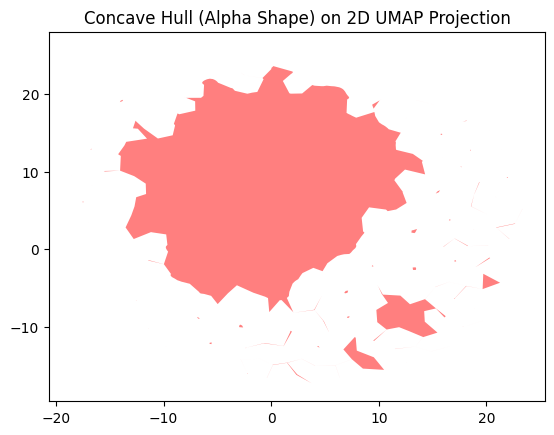

In [34]:
import warnings
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon

warnings.filterwarnings('ignore', category=UserWarning)

# Approach 3: Concave Hull (Alpha Shape)
alpha_shape = alphashape(umap_train_data, 1.0)

# Check if the alpha shape object is a MultiPolygon or Polygon
if isinstance(alpha_shape, MultiPolygon):
    for shape in alpha_shape.geoms: 
        x,y = shape.exterior.xy
        plt.fill(x, y, alpha=0.5, fc='r', label="Alpha=1.0")
else:
    x,y = alpha_shape.exterior.xy
    plt.fill(x, y, alpha=0.5, fc='r', label="Alpha=1.0")

plt.title("Concave Hull (Alpha Shape) on 2D UMAP Projection")
plt.show()


In [ ]:

# Assuming threshold is set for each approach
# Outlier detection for test data based on KDE
is_outlier_test_kde = density_test < threshold_kde

# Mapping back to original high-dimensional space
original_test_data_kde_outliers = pca.inverse_transform(umap_model.inverse_transform(umap_test_data[is_outlier_test_kde]))

In [ ]:
# Visualizations using Pairplot and Parallel Coordinates
sns.pairplot(pd.DataFrame(original_test_data_kde_outliers, columns=selected_features))
plt.title("Pairplot of Outliers Based on KDE")
plt.show()

# Parallel Coordinates (assuming df is a DataFrame containing the data)
plt.figure()
pd.plotting.parallel_coordinates(df[df['is_outlier_kde']], 'Mode')  # Assuming 'Mode' and 'is_outlier_kde' are columns in df
plt.title("Parallel Coordinates of Outliers Based on KDE")
plt.show()